# 果蔬识别

对于眼睛视力不好的老人，在超市购物时就需要别人帮助来取菜、称重，这就让老人的生活更加困难。  
这里我们开发了在移动端就可以识别并语音提示的app，老人可以利用手机来帮助确定手中的蔬菜，这就在一定程度上避免了买菜时无人帮助的麻烦。  
  
果蔬识别的主要原理是利用了模型的微调技术。  
主干网络采用的经过ImageNet预训练的MobileNetV2，这个模型具有体积小，准确率高的特点，非常适合在手机端运行。
主干网络输出的结果再经过新加入的层，按照果蔬类别分类。

## 加载模块

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

## ImageNet分类器  

我们使用预训练的ImageNet分类器。Google提供了经典网络结构的预训练模型，这样就可以直接使用训练好的参数。  

下载分类器  
[TensorFlow Hub](https://www.tensorflow.org/hub?hl=zh-cn)是一个包含经过训练的机器学习模型的代码库。  
可以采用直接下载的方式进行下载，或者下载好后，可以指定到相对应的文件夹进行读取。

In [3]:
# mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
mobilenet_v2 = "./tf2_mobilenetv2"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

hub.KerasLayer是 TensorFlow Hub (tfhub.dev) 中的一个实用程序，允许您使用 TensorFlow Hub 中的预训练模型作为 TensorFlow 或 Keras 模型中的层。

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

2023-10-27 09:08:40.306246: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 09:08:41.300194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10396 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-10-27 09:08:41.301012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10410 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


### 预训练模型图像处理实验  
从训练文件夹中任意选取一张图片，我们先查看一下图片的内容：

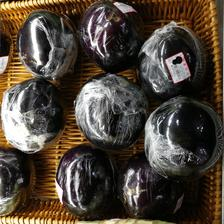

In [38]:
img_path = './train_V_224/eggplant/vegandfruit-995.jpg'
eggplant = Image.open(img_path).resize(IMAGE_SHAPE)
eggplant
# Convert the PIL image to a NumPy array
# image_np = tf.image.convert_image_dtype(np.array(image_pil), tf.float32)

首先将这个图像从0 ~ 255变换到0 ~ 1

In [6]:
eggplant = np.array(eggplant)/255.0
eggplant.shape

(224, 224, 3)

eggplant[np.newaxis, ...]将数据由(224, 224, 3)变换为(1, 224, 224, 3)  
然后放入的分类器中

In [7]:
result = classifier.predict(eggplant[np.newaxis, ...])
result.shape

2023-10-27 09:08:43.504043: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2023-10-27 09:08:43.940345: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


(1, 1001)

因为ImageNet有1001种不同分类，所以这里的输出也是1001  
具体的值表示每一种分类的概率  
这里使用tf.math.argmax计算出结果的最大值，也就是最有可能的分类

In [8]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=729>

### 预测值的意义

获取 Predicted_class ID（729）并获取 ImageNet 数据集标签来解码预测：

In [9]:
labels_path = 'ImageNetLabels.txt'
imagenet_labels = np.array(open(labels_path).read().splitlines())

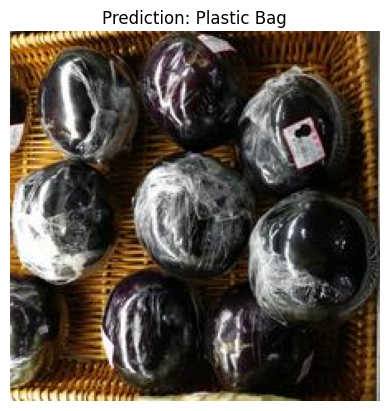

In [10]:
plt.imshow(eggplant)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## 简单的迁移学习

如何利用已有的网络进行迁移学习呢？
1. 从TensorFlow Hub选择一个预训练好的模型
2. 重新设计模型的顶层结构来识别你的数据

### Dataset

In [11]:
data_root = 'train_V_224/'

第一步，使用 tf.keras.utils.image_dataset_from_directory加载磁盘上的数据文件生成tf.data.Dataset文件类型：

In [12]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 4741 files belonging to 9 classes.
Using 3793 files for training.
Found 4741 files belonging to 9 classes.
Using 948 files for validation.


果蔬识别模型有9个不同的类：

In [13]:
class_names = np.array(train_ds.class_names)
print(class_names)
val_class_names = np.array(val_ds.class_names)
print(val_class_names)

['apple' 'bean' 'cabbage' 'carrot' 'cauliflower' 'cucumber' 'eggplant'
 'mashroom' 'pitaya']
['apple' 'bean' 'cabbage' 'carrot' 'cauliflower' 'cucumber' 'eggplant'
 'mashroom' 'pitaya']


第二步，TensorFlow Hub模型处理图像时，输出的数据应该为浮点型，在[0,1]之间。这里使用tf.keras.layers.Rescaling来预处理图像。

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

第三，通过 Dataset.prefetch 使用缓冲预取来完成输入的pipeline，这样就可以从磁盘生成数据，而不会出现 I/O 阻塞问题。

这些是加载数据时应使用的一些最重要的 tf.data 方法。 同学们可以在《使用 tf.data API 获得更好的性能》指南中了解更多相关信息，以及如何将数据缓存到磁盘和其他技术。

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

我们可以验证一个batch的数据，看他们是否合适：

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2023-10-27 09:08:45.178679: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### 预测一个batch的图像

In [17]:
result_batch = classifier.predict(train_ds)

In [18]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Granny Smith', 'hair slide', 'head cabbage', ..., 'hotdog',
       'sarong', 'lipstick'], dtype='<U30')

核对一下预测结果和图像内容的差别：

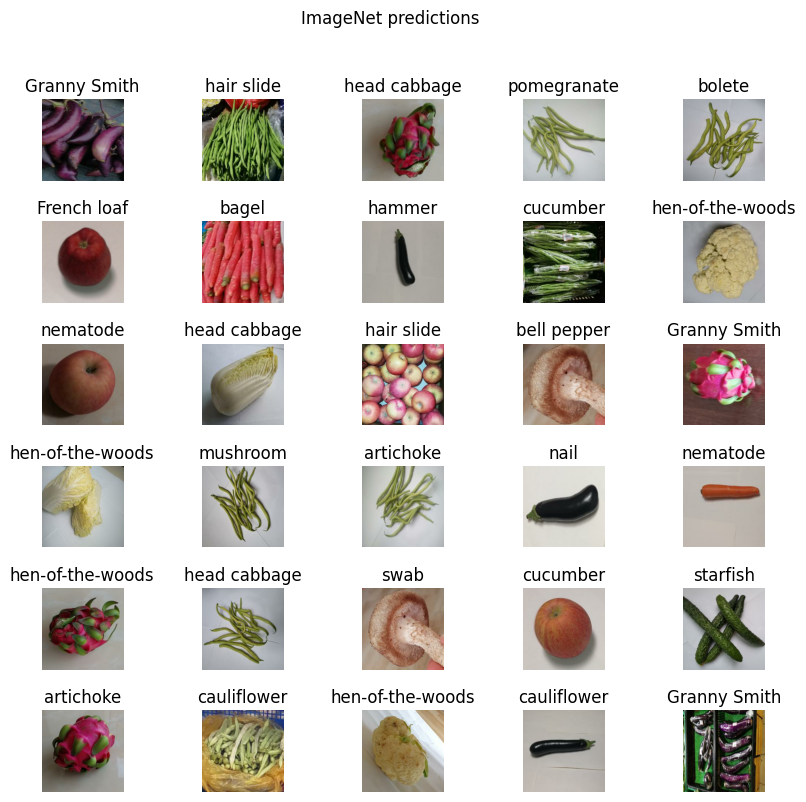

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

预测结果和真实内容的差别还是比较大，原因是模型并不是针对果蔬训练的，所以这个差别还是可以理解的。

## 下载没有顶部的模型

TensorFlow Hub 还分发没有顶层分类层的模型。 这些可用于轻松执行迁移学习。  
和前面的方法一下，如果不能直接下载，请下载后解压，并给模型指定明确的路径。  

In [20]:
# mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenet_v2 = './tf2_mobilenetv2_feature'
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

通过使用 hub.KerasLayer 将预训练模型包装为 Keras 层来创建特征提取器。 使用 trainable=False 参数冻结变量，以便训练仅修改新的分类器层：

In [21]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

特征提取器为每个图像返回一个 1280 长的向量（在本例中图像批量大小保持为 32）：  
1280就是网络层最后的输出（向顶层）

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### 增加针对果蔬的分类顶层：

要完成模型的设计，将特征提取器层包装在 tf.keras.Sequential 模型中，并添加用于分类的全连接层：  

In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 9)                 11529     
                                                                 
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([32, 9])

## Train the model
使用 Model.compile 配置训练过程并添加 tf.keras.callbacks.TensorBoard 回调来创建和存储日志：

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

现在使用 Model.fit 方法来训练模型。

为简单起见，我们将仅训练 10 个 epoch。 要稍后在 TensorBoard 中可视化训练进度，请创建日志并将其存储在 TensorBoard 回调中。

In [27]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
119/119 [==============================] - 8s 51ms/step - loss: 0.2811 - acc: 0.9254 - val_loss: 0.0484 - val_acc: 0.9937
Epoch 2/10
119/119 [==============================] - 5s 44ms/step - loss: 0.0227 - acc: 0.9982 - val_loss: 0.0240 - val_acc: 0.9968
Epoch 3/10
119/119 [==============================] - 5s 44ms/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 0.9989
Epoch 4/10
119/119 [==============================] - 5s 44ms/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9989
Epoch 5/10
119/119 [==============================] - 5s 44ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 0.9989
Epoch 6/10
119/119 [==============================] - 5s 44ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0090 - val_acc: 0.9989
Epoch 7/10
119/119 [==============================] - 5s 44ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0081 - val_acc: 0.9989
Epoch 8/10
119/119 [==============================] - 5s 44ms/step - 

启动 TensorBoard 以查看训练的各项参数如何随每个时期变化并跟踪其他标量值：  
--host 192.168.1.103指明训练的机器在局域网的其他电脑上，如果你在本机上训练请不要它

In [29]:
%tensorboard --logdir logs/fit --host 192.168.1.103

## 预测

从模型预测中获取类名：

In [30]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['eggplant' 'bean' 'pitaya' 'bean' 'bean' 'apple' 'carrot' 'eggplant'
 'bean' 'cauliflower' 'apple' 'cabbage' 'apple' 'mashroom' 'pitaya'
 'cabbage' 'bean' 'bean' 'eggplant' 'carrot' 'pitaya' 'bean' 'mashroom'
 'apple' 'cucumber' 'pitaya' 'bean' 'cauliflower' 'eggplant' 'eggplant'
 'eggplant' 'carrot']


画出图像并写出预测值

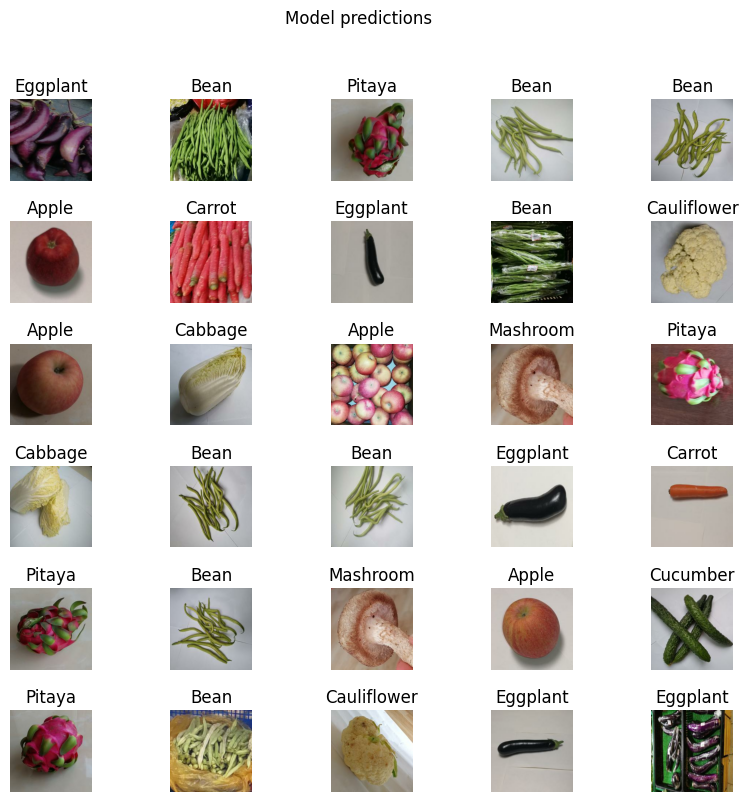

In [31]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## 导出并重载模型

model里保存了已经训练好的模型，我们使用model.save将训练好的参数保存下来：

In [32]:
t = time.time()

export_path = "saved_models/{}".format(int(t))
model.save(export_path)

export_path

2023-10-27 09:14:46.892992: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/1698369285/assets


'saved_models/1698369285'

重载模型确保模型可以被再次使用并输出相同的结果：

In [33]:
reloaded = tf.keras.models.load_model(export_path)

In [34]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [35]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [36]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['eggplant' 'bean' 'pitaya' 'bean' 'bean' 'apple' 'carrot' 'eggplant'
 'bean' 'cauliflower' 'apple' 'cabbage' 'apple' 'mashroom' 'pitaya'
 'cabbage' 'bean' 'bean' 'eggplant' 'carrot' 'pitaya' 'bean' 'mashroom'
 'apple' 'cucumber' 'pitaya' 'bean' 'cauliflower' 'eggplant' 'eggplant'
 'eggplant' 'carrot']


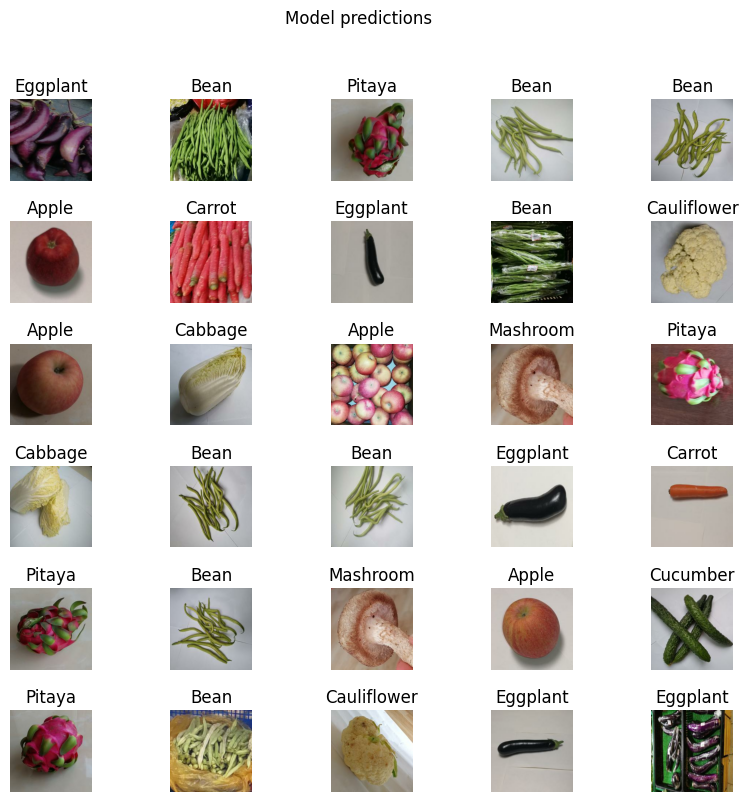

In [37]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## 测试Test数据集

In [41]:
test_root = 'test_V/'

In [42]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  str(test_root),
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 520 files belonging to 9 classes.


In [43]:
class_names = np.array(test_ds.class_names)
print(class_names)

['apple' 'bean' 'cabbage' 'carrot' 'cauliflower' 'cucumber' 'eggplant'
 'mashroom' 'pitaya']


In [44]:
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [45]:
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2023-10-27 10:52:22.927724: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [47]:
reloaded_result_batch = reloaded.predict(image_batch)

In [48]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)

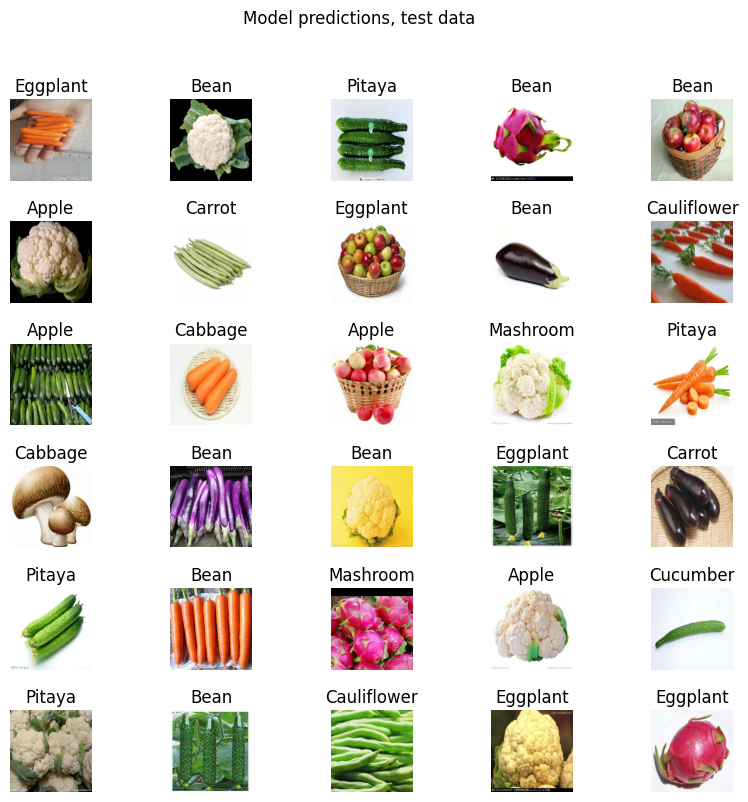

In [49]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions, test data")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(reloaded)
tflite_model = converter.convert()
open("mobile.tflite", "wb").write(tflite_model)

## 参考

1. [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub)
2. [Keras](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
3. https://www.cnblogs.com/zhixingheyi/p/8097782.html
4. https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
5. https://www.youtube.com/watch?v=8Oog7TXHvFY
6. https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

